# Model fit

The likelihood function (often simply called the *likelihood*) is the joint probability (or probability density) of observed data viewed as a function of the parameters of a statistical model. By combining the likelihood function to a code able to explore the parameter space of our model (or a *sampler*), we can determine the probability density of the model parameters given the data, or *posteriors*. The posteriors of our model effectively represents the final results of our analysis.

## Likelihood function

We consider N observations of a variable $\boldsymbol{y} = \{y_i \}_{i=1,...,N}$, taken at times $\boldsymbol{t} = \{t_i\}$, with associated measurement uncertainties $\boldsymbol{\sigma} = \{\sigma_i\}$. Wew wish to compare these to a model function  $m \left( t_i, \boldsymbol{\theta} \right) $ controlled by parameters $\boldsymbol{\theta} = \{ \theta_j \}_{j=1,...,M}$.

Let us assume that the observations are given by  

$y_i = m \left( t_i, \theta \right) + \epsilon_i$

where $\epsilon_i$ is the measurement error, or noise, of the $i^{\textrm{th}}$ observation. 

Let us assume that $\epsilon_i$ is drawn from a Gaussian dristribution with mean $0$ and variance $\sigma_i^2$:

$p(\epsilon_i) = \mathcal{N}(0, \sigma_i^2) \equiv \frac{1}{\sqrt{2 \pi} \sigma_i} \exp{\left( -\frac{\epsilon_i^2}{2\sigma_i^2} \right) }$

Then the likelihood for the $i^{\textrm{th}}$ observation is simply:

$\mathcal{L}_i(\boldsymbol{\theta}) \equiv p(y_i | \boldsymbol{\theta}) =  \mathcal{N}(m_i, \sigma_i^2) =  \frac{1}{\sqrt{2 \pi} \sigma_i} \exp{\left[ -\frac{(y_i-m_i)^2}{2\sigma_i^2} \right] }$ 

We also assume that the noise is uncorrelated, or *white*, meaning that each $\epsilon_i$ is drawn from its corresponding distribution, indepedently from the others. Then, the likelihood for the whole dataset $\boldsymbol{y}$ is merely the product of the likelihoods for the individual observations:

$\mathcal{L}(\boldsymbol{\theta}) \equiv p(\boldsymbol{y} |\boldsymbol{\theta}) = 
\prod_{i=1}^N \mathcal{L}_i = \prod_{i=1}^N \left\{ \frac{1}{\sqrt{2 \pi} \sigma_i} \exp{\left[ -\frac{(y_i-m_i)^2}{2\sigma_i^2} \right] } \right\}$ 

The natural logarithm of $\mathcal{L}$ is equal to:

$\ln{\mathcal{L}} =  -0.5  N \ln{2 \pi} - \sum\limits_{i=1}^{N}(\ln{\sigma_i}) - 0.5 \chi^2 $

Where $\chi^2$ is equal to the weighted sum of squared deviations

$\chi^2 = \sum\limits_{i=1}^n \frac{(y_i-m_i)^2}{\sigma_i^2}  $

The above equation can be rewritten as:

$\ln{\mathcal{L}} =  -0.5 \left[ N \ln{2 \pi} + \chi^2 + \sum\limits_{i=1}^{N}  \left( \ln{\sigma_i^2} \right) \right] $


## Building the log_likelihood function

Let's load our data first.
For this example, I'll load the SAP photometry flattened using the Huber spline. You have to load the photometry that you evaluated as the best one according to the analysis performed on the TESS flattened light curves.


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits 
import pickle
import os
%matplotlib widget

taste_bjd_tdb = pickle.load(open('../TASTE/output_files/taste_bjdtdb.p','rb'))
differential_ap08_allref = pickle.load(open('../TASTE/output_files/differential_ap08_allref.p','rb'))
differential_ap08_allref_error = pickle.load(open('../TASTE/output_files/differential_ap08_allref_error3.p','rb'))


tess_bjd_tdb = pickle.load(open('../TESS/output_files/TESS_sector43_bjd_tdb.p','rb'))
sap_masked_huberspline = pickle.load(open('../TESS/output_files/TESS_sector43_sap_masked_huberspline.p','rb'))
sap_masked_huberspline_error = pickle.load(open('../TESS/output_files/TESS_sector43_sap_masked_huberspline_error.p','rb'))



As we have seen in the previous lecture, our model encompassed the following parameters, common to both TASTE and TESS datasets. Let's list them from zero, i.e., using the Python notation, for reasons that will become crlear later on.  In this list, we are not including parameters that will keep a fixed value, such as eccentricity.

0) `params.t0` : time of inferior conjunction
1) `params.per`: orbital period of the planet, in days
2) `params.rp`: scaled planetary radius, i.e., planet radius in units of stellar radii
3) `params.a`: scaled semi-major axis, i.e., semi-major axis in units of stellar radii
4) `params.inc`: orbital inclination in degrees


For TESS, we have to include two additional parameters for the limb darkening coefficients:

5) TESS limb darkening coefficient `u1`
6) TESS limb darkening coefficient `u2`

For TASTE, we have to include again two additional parameters for the limb darkening coefficients, and three parameters for the coefficient of the *quadratic* polynomial trend. 

7) TASTE limb darkening coefficient `u1`
8) TASTE limb darkening coefficient `u2`
9) zero-th order coefficient for the polynomial trend
10) first order coefficient for the polynomial trend
11) second order coefficient for the polynomial trend

Finally, we add two extra parameters, called *jitter parameters*, which are not used by the model but are instead added in quadrature to estimate our errors. These parameters will compensate for any source of errors that we have not included in our estimates until now. An example can be found [in this paper](https://ui.adsabs.harvard.edu/abs/2020AJ....159..235L/abstract).

12) jitter parameter for TESS data
13) jitter parameter for TASTE data

We have a total of 14 parameters (remember, we started counting from zero. Let's rewrite our model including the array `theta` in our modelling, rather than using the specific values. Pay attention to follow closely the numbering above (that's why we started from zero...) 


In [2]:
theta = np.empty(14)

#params.t0 =  2459688.443452                      #time of inferior conjunction
#params.per =  4.3011975                      #orbital period
#params.rp = 0.1343                      #planet radius (in units of stellar radii)
#...

theta[0] = 2459550.243082 #time of inferior conjunction
theta[1] = 1.0914167      #orbital period
theta[2] = 0.117          #planet radius (in units of stellar radii)
theta[3] = 3.             #semi-major axis (in units of stellar radii)
theta[4] = 83.52          #orbital inclination (in degrees)
theta[5] = 0.41           # TESS LD coeff u1
theta[6] = 0.13           # TESS LD coeff u2
theta[7] = 0.51           # TASTE LD coeff u1
theta[8] = 0.14           # TASTE LD coeff u2
theta[9] = 0.623           # zero-th order coefficient for the polynomial trend
theta[10] = 0.0           # first order coefficient for the polynomial trend
theta[11] = 0.0           # second order coefficient for the polynomial trend
theta[12] = 0.0           # jitter parameter for TESS data
theta[13] = 0.0           # jitter parameter for TASTE data



Let's replace the values in the model with the theta array at the corresponding index. \
Mind the way the two limb darkeing coefficinets are included in the single parameter `params.u`. \
We can leave the value as it is for those parameters we don't want to optimize. 

In [3]:

import batman

params = batman.TransitParams()
params.t0 =  theta[0]                
params.per = theta[1]                    
params.rp =  theta[2]                 
params.a =   theta[3]                   
params.inc =  theta[4]    
params.ecc = 0.
params.w = 90. 
params.u = [theta[5] , theta[6]]
params.limb_dark = "quadratic"

m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_flux =m_tess.light_curve(params)          #calculates light curv

params.u = [theta[7] , theta[8]]
median_bjd = np.median(taste_bjd_tdb)
polynomial_trend = theta[9] + theta[10]*(taste_bjd_tdb-median_bjd) + theta[11]*(taste_bjd_tdb-median_bjd)**2

m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_flux = m_taste.light_curve(params) * polynomial_trend




Note how we *multiply* the model by the polynomial trend, rather than *divide* the data by it. The idea behind this choice is to include all possible effects in the model rather than work on the data. This approach will also avoid the extra step of dividing the associated errors by the polynomial trend. LEt's compare the data with our model:

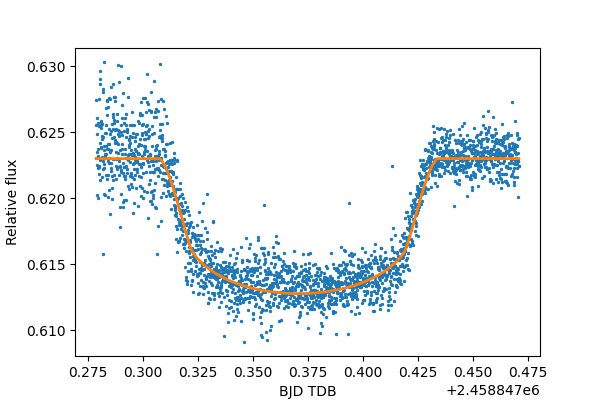

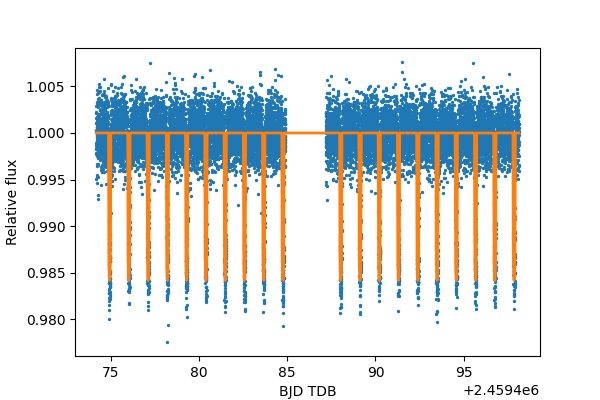

In [4]:
plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, differential_ap08_allref, s=2)
plt.plot(taste_bjd_tdb, taste_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, sap_masked_huberspline, s=2)
plt.plot(tess_bjd_tdb, tess_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()


Let's compute the log-likelihood!

$\ln{\mathcal{L}} =  -0.5 \left[ N \ln{2 \pi} + \chi^2 + \sum\limits_{i=1}^{N}  \left( \ln{\sigma_i^2} \right) \right] $

If we have to datasets, for the properties of the sum the $\chi^2$ and the term with $ \ln{\sigma_i^2}$ are equal to:

$\chi^2 = \chi^2_\mathrm{TESS} + \chi^2_{TASTE}$

$\sum\limits_{i=1}^{N}  \left( \ln{\sigma_i^2} \right) = \sum\limits_{i=1}^{N_\mathrm{TESS}}  \left( \ln{\sigma_i^2} \right) + \sum\limits_{i=1}^{N_\mathrm{TASTE}}  \left( \ln{\sigma_i^2} \right)$

with $N = N_\mathrm{TESS} + N_\mathrm{TASTE}$


The same considerations apply if you have several TESS sectors in addition to the TASTE observations, for example, data coming form TESS sectors 10, 11, and 12:

$\chi^2 = \chi^2_\mathrm{TESS sector10} + \chi^2_\mathrm{TESS sector11} + \chi^2_\mathrm{TESS sector12} + \chi^2_{TASTE}$

$\sum\limits_{i=1}^{N}  \left( \ln{\sigma_i^2} \right) = 
\sum\limits_{i=1}^{N_\mathrm{TESS sector10}}  \left( \ln{\sigma_i^2} \right) + 
\sum\limits_{i=1}^{N_\mathrm{TESS sector11}}  \left( \ln{\sigma_i^2} \right) + 
\sum\limits_{i=1}^{N_\mathrm{TESS sector12}}  \left( \ln{\sigma_i^2} \right) + 
\sum\limits_{i=1}^{N_\mathrm{TASTE}}  \left( \ln{\sigma_i^2} \right)$

with $N = N_\mathrm{TESS sector10} + N_\mathrm{TESS sector11} + N_\mathrm{TESS sector12} + N_\mathrm{TASTE}$

We first start to add in quadrature the jitter to our estimated errors. We don't need to take the square root, as we are going to use the square of the result in the likelihood computation. We then proceed to build the rest of the code.

In [5]:
tess_errors_with_jitter = sap_masked_huberspline_error**2 + theta[12]**2
taste_errors_with_jitter = differential_ap08_allref_error**2 + theta[13]**2

N = len(tess_errors_with_jitter) + len(taste_errors_with_jitter)

chi2_tess = np.sum( (sap_masked_huberspline-tess_flux)**2 / tess_errors_with_jitter)
chi2_taste = np.sum( (differential_ap08_allref-taste_flux)**2 / taste_errors_with_jitter)
sum_ln_sigma_tess = np.sum(np.log(tess_errors_with_jitter))
sum_ln_sigma_taste = np.sum(np.log(taste_errors_with_jitter))

log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_tess + chi2_taste + sum_ln_sigma_tess + sum_ln_sigma_taste)
print('log_likelihood', log_likelihood)

log_likelihood 84318.53359825733


The number by itself is not very useful. What we need to do is to find the combination of parameters that maximise the log-likelihood (and, conversely, minimise the $\chi^2$). To do so, we need to build a function that takes in input the parameter vector $\boldsymbol{\theta}$ and gives us the log-likelihood value in output. In practice, we just have to assemble the last cells' operations inside a function.

In [6]:
def log_likelihood(theta):

    params = batman.TransitParams()
    params.t0 =  theta[0]                
    params.per = theta[1]                    
    params.rp =  theta[2]                 
    params.a =   theta[3]                   
    params.inc =  theta[4]    
    params.ecc = 0.
    params.w = 90. 
    params.u = [theta[5] , theta[6]]
    params.limb_dark = "quadratic"

    m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
    tess_flux =m_tess.light_curve(params)          #calculates light curv

    params.u = [theta[7] , theta[8]]
    median_bjd = np.median(taste_bjd_tdb)
    polynomial_trend = theta[9]+theta[10]*(taste_bjd_tdb-median_bjd) + theta[11]*(taste_bjd_tdb-median_bjd)**2

    m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
    taste_flux = m_taste.light_curve(params) * polynomial_trend

    
    tess_errors_with_jitter = sap_masked_huberspline_error**2 + theta[12]**2
    
    taste_errors_with_jitter = differential_ap08_allref_error**2 + theta[13]**2

    N = len(tess_errors_with_jitter) + len(taste_errors_with_jitter)

    chi2_tess = np.sum( (sap_masked_huberspline-tess_flux)**2 / tess_errors_with_jitter)
    chi2_taste = np.sum( (differential_ap08_allref-taste_flux)**2 / taste_errors_with_jitter)

    sum_ln_sigma_tess = np.sum(np.log(tess_errors_with_jitter))
    sum_ln_sigma_taste = np.sum(np.log(taste_errors_with_jitter))

    log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_tess + chi2_taste + sum_ln_sigma_tess + sum_ln_sigma_taste)
    return log_likelihood

print('log_likelihood', log_likelihood(theta))


log_likelihood 84318.53359825733


**Note**: 
- you can use the same TESS limb darkening for all TESS sectors
- you can use the same jitter parameters for all TESS sectors, for example:
```python
    tess_sector10_errors_with_jitter = sap_sector10_masked_huberspline_error**2 + theta[12]**2
    tess_sector11_errors_with_jitter = sap_sector11_masked_huberspline_error**2 + theta[12]**2
    tess_sector12_errors_with_jitter = sap_sector12_masked_huberspline_error**2 + theta[12]**2
```
Consequently, you don't need to introduce additional parameters in the model if you work with more than one TESS sector.

## Define the prior

These are the limb darkening coefficients that I retrieved for my filters:

- Sloan r LD coefficients: $u1 = 0.51 \pm 0.02 \qquad   u2 = 0.14 \pm 0.05$
- TESS LD coefficients   : $u1 = 0.41 \pm 0.02 \qquad   u2 = 0.13 \pm 0.04$

How do I incorporate this information in the computation of the posterior? 
The Bayes theorem says:

$$P \left(x|D \right) = \frac{P \left( D|x \right) P\left( x \right )}{P \left( D \right)}$$

Our sampler works by taking the natural logarithm of the likelihood, so priors can  be included easily by adding the logarithm of the probability density function of the parameters over which we want to impose a prior.

The probability density function can be easily computed using `scipy`:

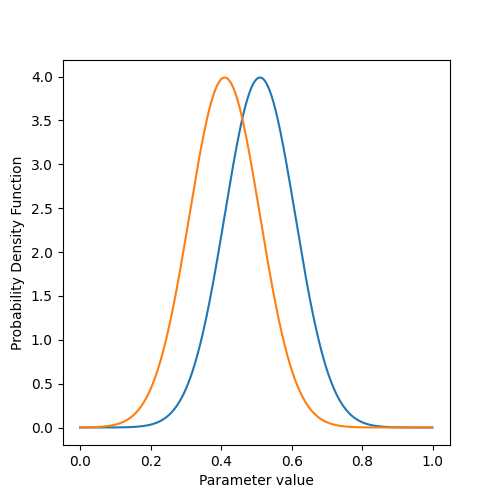

In [7]:
# prior on c1: 0.59 \pm 0.10
from scipy import stats

x_range=np.arange(0.00, 1.00, 0.001)
y1_plot = stats.norm.pdf(x_range, loc=0.51, scale=0.10)
y2_plot = stats.norm.pdf(x_range, loc=0.41, scale=0.10)
plt.figure(figsize=(5,5))
plt.plot(x_range, y1_plot)
plt.plot(x_range, y2_plot)
plt.xlabel('Parameter value')
plt.ylabel('Probability Density Function')
plt.show()

To correctly assign the prior, we need to keep track of the index associated with the parameters with explicit prior. 
Keep in mind that *all parameters* will have some kind of prior. If not explicitly stated, the prior is *uniform*, i.e., a constant value for the probability density distribution. 


In [8]:
theta[5] = 0.41           # TESS LD coeff u1
theta[6] = 0.13           # TESS LD coeff u2
theta[7] = 0.51           # TASTE LD coeff u1
theta[8] = 0.14           # TASTE LD coeff u2

def log_prior(theta):
    prior = 0.00
    prior+= np.log(stats.norm.pdf(theta[5], loc=0.41, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[6], loc=0.13, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[7], loc=0.51, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[8], loc=0.14, scale=0.10))
    return prior

# Define the boundaries
Defining the boundaries of our parameters is not explicitly required by the sampler we employ, but it may be compulsory for other samplers. In general, proving boundaries for the parameter spaces is always helpful as it will avoid exploring unphysical parameter combinations (negative periods, negative radii...). 

The boundary array is a two-dimensional array, with one dimension equal to the number of parameters of the model and the other dimension equal to two. Written in this way, it will be trivial to check if the $\boldsymbol{\theta}$ array is within the boundaries

In [9]:

theta[0] = 2459550.243082 #time of inferior conjunction
theta[1] = 1.0914167      #orbital period
theta[2] = 0.117          #planet radius (in units of stellar radii)
theta[3] = 3.             #semi-major axis (in units of stellar radii)
theta[4] = 83.52          #orbital inclination (in degrees)
theta[5] = 0.41           # TESS LD coeff u1
theta[6] = 0.13           # TESS LD coeff u2
theta[7] = 0.51           # TASTE LD coeff u1
theta[8] = 0.14           # TASTE LD coeff u2
theta[9] = 0.623           # zero-th order coefficient for the polynomial trend
theta[10] = 0.0           # first order coefficient for the polynomial trend
theta[11] = 0.0           # second order coefficient for the polynomial trend
theta[12] = 0.0           # jitter parameter for TESS data
theta[13] = 0.0           # jitter parameter for TASTE data


boundaries = np.empty([2, len(theta)])

boundaries[:,0] = [theta[0]-0.5, theta[0]+0.5]
boundaries[:,1] = [theta[1]-0.5, theta[1]+0.5]
boundaries[:,2] = [0.0, 0.5]
boundaries[:,3] = [0.0, 20.]
boundaries[:,4] = [0.00, 90.0]
boundaries[:,5] = [0.00, 1.0]
boundaries[:,6] = [0.00, 1.0]
boundaries[:,7] = [0.00, 1.0]
boundaries[:,8] = [0.00, 1.0]
boundaries[:,9] = [0.00, 1.0]
boundaries[:,10] = [-1.0, 1.0]
boundaries[:,11] = [-1.0, 1.0]
boundaries[:,12] = [0.0, 0.05]
boundaries[:,13] = [0.0, 0.05]


If $\boldsymbol{\theta}$ is outside the range, the `log_probability` will be `-np.inf`, and the sampler will reject the step. Otherwise, the sum of `log_likelihood` and `log_prior` will be computed.

In [10]:
def log_probability(theta):
    
    sel = (theta < boundaries[0,:]) | (theta >   boundaries[1,:])
    if np.sum(sel) > 0:
        return -np.inf
    
    log_prob = log_prior(theta)
    log_prob += log_likelihood(theta)
    return log_prob

In [11]:
print('log_probability', log_probability(theta))

log_probability 84324.06818449649


## Running the MCMC sample

To optimize the `log_likelihood` function, we are going to use the [Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler](https://msp.org/camcos/2010/5-1/p04.xhtml) called `emcee` ([Foreman-Mackey et al. 2013](https://ui.adsabs.harvard.edu/abs/2013PASP..125..306F/abstract), [GitHub page](https://github.com/dfm/emcee), [Documentation page](https://emcee.readthedocs.io/en/stable/)). 

To run `emcee`, we need to define:
- the number of *walkers*: `nwalkers`
- the number of *steps*: `nsteps` 
- the number of parameters: `ndim`

The number of walkers needs to be *at least* twice the number of parameters for the algorithm to work properly (this is a specific requirement of the affine invariant MCMC). The number of steps must be long enough for the chains to converge and mix. Note that:

- increasing the walker will make each iteration slower
- increasing the steps will make the total time longer 



In [12]:
nwalkers = 50
nsteps = 20000
ndim = len(theta)

import emcee

We also need to provide a starting point for the MCMC. 
We can safely use the `theta` that we have built earlier, with a caveat: the sampler requires each chain to be initialized at a slightly different position with respect to the other, so we are going to build an array with shape `(nwalkers, ndim)` by *perturbing* our starting point $\boldsymbol{\theta}$ by a small value. Since most of our starting values correspond to their lower boundary, we impose a positive perturbation for all variables (we could be selective, but the effort is not worth it). 


In [13]:

#We initialize the walkers in a tiny Gaussian ball around our approximate result
starting_point = theta + np.abs(1e-5 * np.random.randn(nwalkers, ndim))


It's quite slow, let's try a trick with `multiprocessing`:

In [14]:
# PROF (ubuntu)
from multiprocessing import Pool

file_path = 'output_files/emcee_sampler_first_run.p'

if os.path.exists(file_path):
    sampler = pickle.load(open('output_files/emcee_sampler_first_run.p','rb'))
    print('Output file exists. Skipping multiprocessing and importing the existing file.')
else:
    if __name__ == "__main__":
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
            sampler.run_mcmc(starting_point, nsteps, progress=True)

        pickle.dump(sampler, open('output_files/emcee_sampler_first_run.p','wb'))


# GIADA (macos)
'''
from multiprocess import Pool

file_path = './output_files/emcee_sampler_first_run.p'

if os.path.exists(file_path):
    sampler = pickle.load(open('./output_files/emcee_sampler_first_run.p','rb'))
    print('Output file exists. Skipping multiprocessing and importing the existing file.')
else:
    if __name__ == "__main__":
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
            sampler.run_mcmc(starting_point, nsteps, progress=True)

        pickle.dump(sampler, open('./output_files/emcee_sampler_first_run.p','wb'))
'''


Output file exists. Skipping multiprocessing and importing the existing file.


'\nfrom multiprocess import Pool\n\nfile_path = \'./output_files/emcee_sampler_first_run.p\'\n\nif os.path.exists(file_path):\n    sampler = pickle.load(open(\'./output_files/emcee_sampler_first_run.p\',\'rb\'))\n    print(\'Output file exists. Skipping multiprocessing and importing the existing file.\')\nelse:\n    if __name__ == "__main__":\n        with Pool() as pool:\n            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)\n            sampler.run_mcmc(starting_point, nsteps, progress=True)\n\n        pickle.dump(sampler, open(\'./output_files/emcee_sampler_first_run.p\',\'wb\'))\n'

## Analysis of the results

We can visualize the chain to verify that the MCMC has reached convergence. Only four parameters are shown in this example, for your analysis you must check them all. 

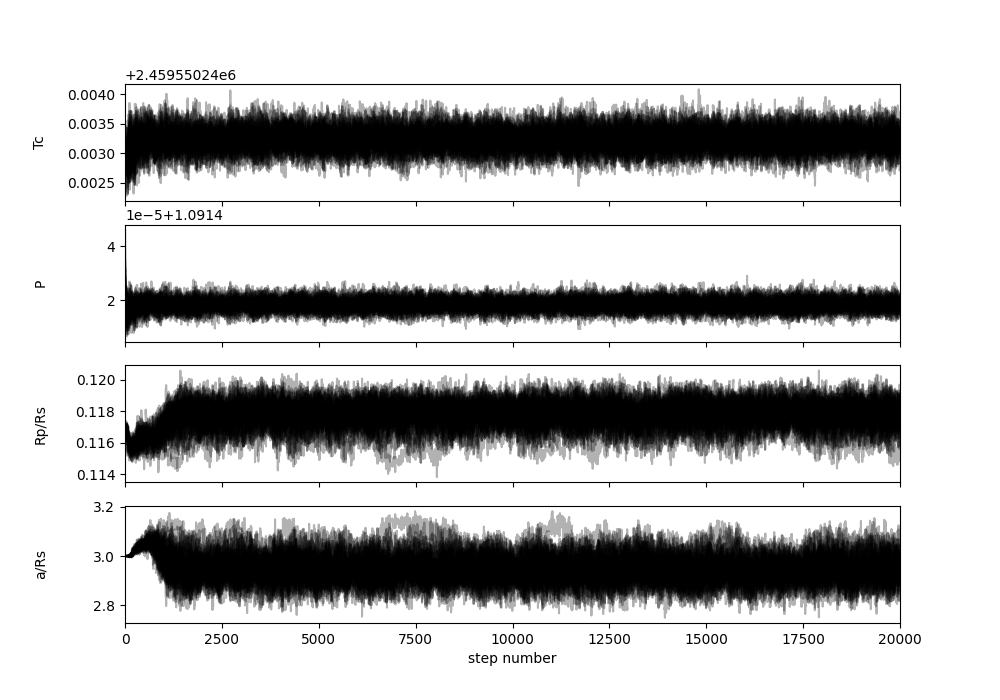

In [15]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ["Tc", "P", "Rp/Rs", "a/Rs"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

To extract the chains from the output, we rely on the help provided by the documentation. 
After applying the burn-in cut and thinning the chains, the chains of each parameter are all merged into a *flat* distribution. We are using this one to estimate the error for each parameter.

**Don't forget to fix the significant figures**

In [16]:
#https://emcee.readthedocs.io/en/stable/tutorials/quickstart/

flat_samples = sampler.get_chain(discard=2500, thin=100, flat=True)
print(flat_samples.shape)

from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))
    

(8750, 14)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Finally, we can plot the corner plot, highlighting possible correlations between parameters and non-Gaussian posterior distributions. Make some effort to improve the quality of this plot, by following the example provided in the [documentation of the code](https://corner.readthedocs.io/en/latest/) or using a different code, such as [pygtc](https://pygtc.readthedocs.io/en/latest/)

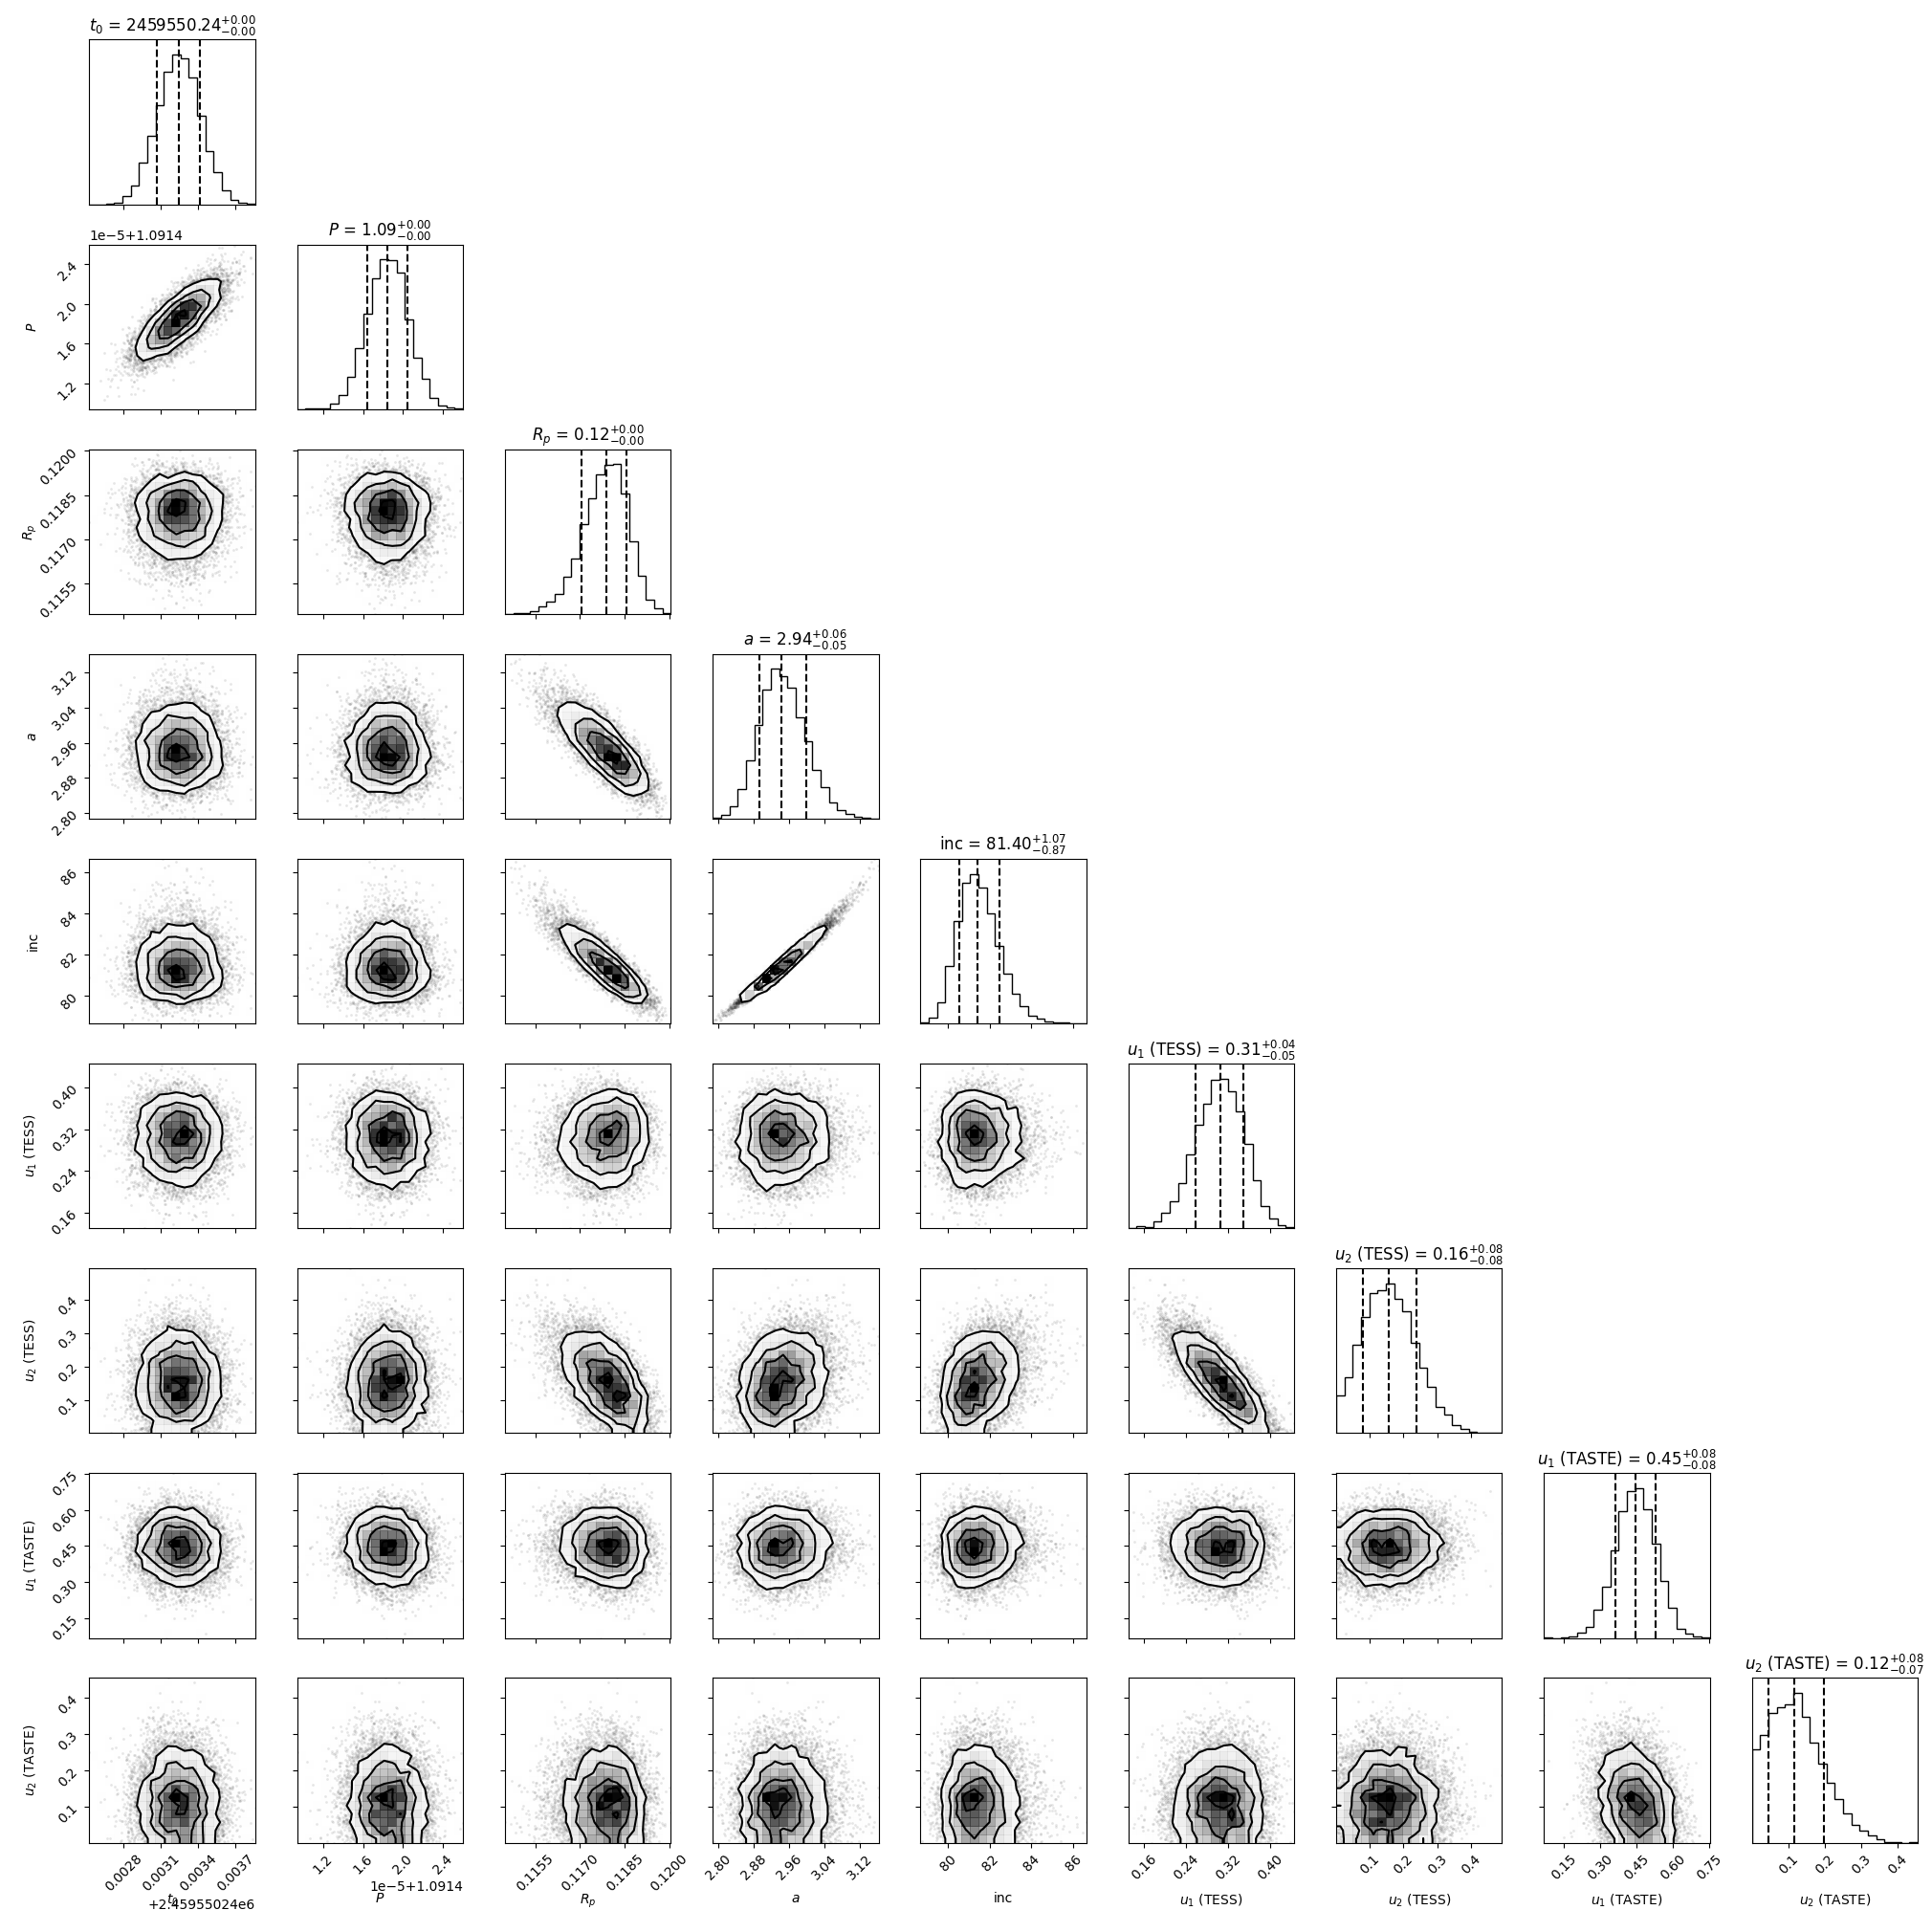

In [17]:
import corner

#fig = plt.figure(figsize=(8,8))
figure = corner.corner(
    flat_samples[:,0:9],
    labels=[
        r'$t_0$',
        r'$P$',
        r'$R_p$',
        r'$a$',
        r'inc',
        r'$u_1$ (TESS)',
        r'$u_2$ (TESS)',
        r'$u_1$ (TASTE)',
        r'$u_2$ (TASTE)'
    ],
    quantiles=[0.16, 0.5, 0.84],
     show_titles=True,
     title_kwargs={"fontsize": 12}
)

plt.tight_layout()
#plt.show() 


Finally, you can overplot the model over your data by using the median values of the parameters' posteriors. Again, do not stop at the example provided here (things are missing) but try to improve the plots.

In [18]:
theta = np.median(flat_samples, axis=0)

params = batman.TransitParams()
params.t0 =  theta[0]                
params.per = theta[1]                    
params.rp =  theta[2]                 
params.a =   theta[3]                   
params.inc =  theta[4]    
params.ecc = 0.
params.w = 90. 
params.u = [theta[5] , theta[6]]
params.limb_dark = "quadratic"

m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_flux =m_tess.light_curve(params)          #calculates light curv

params.u = [theta[7] , theta[8]]
median_bjd = np.median(taste_bjd_tdb)
polynomial_trend = theta[9] #+ theta[10]*(taste_bjd_tdb-median_bjd) + theta[11]*(taste_bjd_tdb-median_bjd)**2

m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_flux = m_taste.light_curve(params) * polynomial_trend


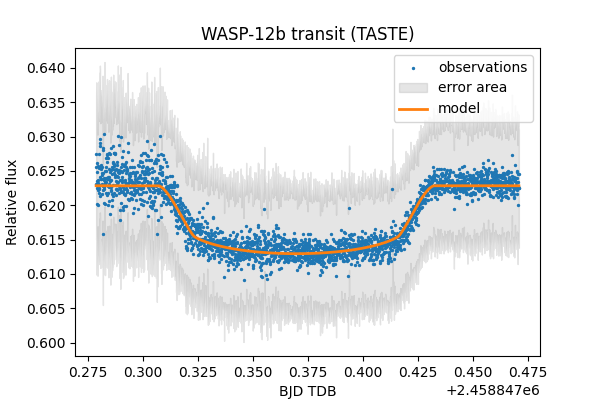

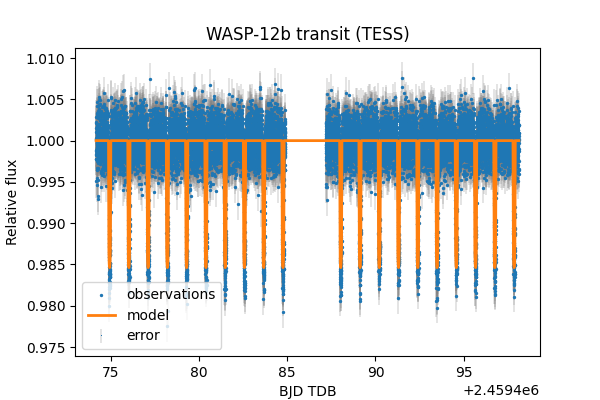

In [31]:
# plot the result

plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, differential_ap08_allref, s=2, zorder=2, label='observations')
#plt.errorbar(taste_bjd_tdb, differential_ap08_allref, yerr=differential_ap08_allref_error, fmt=',', elinewidth=0.2, ecolor='grey', zorder=1)
plt.fill_between(taste_bjd_tdb, differential_ap08_allref - differential_ap08_allref_error, differential_ap08_allref + differential_ap08_allref_error, color='grey', alpha=0.2, label='error area')
plt.plot(taste_bjd_tdb, taste_flux, lw=2, c='C1', zorder=3, label='model')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.title('WASP-12b transit (TASTE)')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, sap_masked_huberspline, s=2, zorder=2, label='observations')
plt.errorbar(tess_bjd_tdb, sap_masked_huberspline, yerr=sap_masked_huberspline_error, fmt=',', elinewidth=0.3, ecolor='grey', zorder=1, label='error')
plt.plot(tess_bjd_tdb, tess_flux, lw=2, c='C1', zorder=3, label='model')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.title('WASP-12b transit (TESS)')
plt.legend()
plt.show()

In [20]:
folded_tess_time = (tess_bjd_tdb - params.t0 - params.per/2. ) % params.per - params.per/2. 
folded_range = np.arange(- params.per/2.,  params.per/2., 0.001)

params.t0 = 0.                     #time of inferior conjunction
m_folded_tess = batman.TransitModel(params, folded_range)    #initializes model
tess_folded_flux =m_folded_tess.light_curve(params)          #calculates light curv

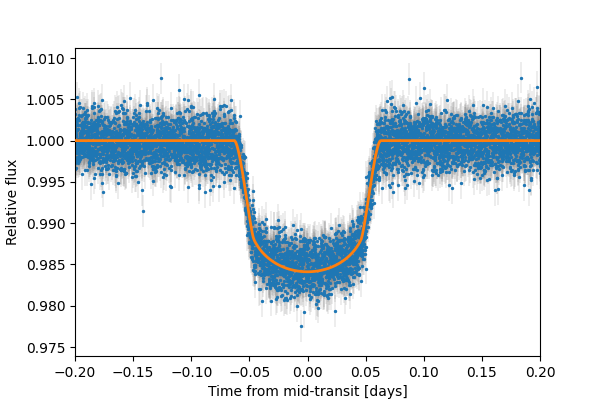

In [21]:
plt.figure(figsize=(6,4))
plt.scatter(folded_tess_time, sap_masked_huberspline, s=2, zorder=2)
plt.errorbar(folded_tess_time, sap_masked_huberspline, yerr=sap_masked_huberspline_error, fmt=',', elinewidth=0.2, ecolor='grey', zorder=1)
plt.plot(folded_range, tess_folded_flux, lw=2, c='C1', zorder=3)
plt.xlim(-0.2, 0.2)
plt.xlabel("Time from mid-transit [days]")
plt.ylabel("Relative flux")
plt.show()

You can finally obtain any derived parameters from your posteriors. For example, to get the planetary radius in physical units, you need to multiply the scaled planetary radius (from the fit) by the stellar radius in solar units (from the literature) and then  multiply it by the ratio of the radii between the Sun and Jupyter to get the value in Jupiter radii. You can easily account for the error associated with the stellar radius by creating a Normal distribution with the same size as the number of samples and a standard deviation equal to the associated error (assuming a normal symmetric distribution).

In [22]:
#Stellar radius from Hebb et al. 2009: 1.57 \pm 0.07 R_sun

Rp_Rs = flat_samples[:, 2]
n_samples = len(Rp_Rs)
r_star = np.random.normal(1.57, 0.05, n_samples)

# Radius of the planet in Solar radii multiplied by the ratio of Solar radius over Jupiter radius 
Rp = r_star*Rp_Rs  * (695700 / 71492)
print(np.mean(Rp), np.std(Rp))

1.8006839199142057 0.05831214043546652


Congratulations for discovering your planet! You have everything to write your paper and compare your results with the literature. 

## Optional: Bayesian analysis without a starting point

The sampler we use for our Bayesian analysis requires a starting point, i.e., a more or less accurate knowledge of the solution near the global maximum of the likelihood, or correspondingly the global minimum of the $\chi^2$. 
The selection of the starting point is essential. MCMC samplers are not able to perform a *global* optimization in the sense that they are not designed to find the parameter combination that provides the maximum value of the likelihood. If the starting point is close to a local maximum, then the MCMC will likely be stuck around that solution. 
When approaching a new problem with no prior knowledge of the optimal parameters, there are two possible roads:
- use a Bayesian approach that does not require a starting point, such as the *dynamic nested sampling* [(Higson et al. 2019)](https://ui.adsabs.harvard.edu/abs/2019S%26C....29..891H/abstract), available in several Python implementations ([`dynesty`]
(https://dynesty.readthedocs.io/en/stable/), [`ultranest`](https://johannesbuchner.github.io/UltraNest/index.html)
- Use a non-Bayesian algorithm specifically designed to search for the identification of the parameters corresponding to the maximum value of the likelihood, for example *differential evolution*
[Storn & Price 1997](https://www.metabolic-economics.de/pages/seminar_theoretische_biologie_2007/literatur/schaber/Storn1997JGlobOpt11.pdf), with its Python implementation [`PyDE`](https://github.com/hpparvi/PyDE). In this case, the algorithm's output cannot be used as a posterior. Still, it will represent an optimal starting point for your MCMC analysis. 

Below, you can find an example using `PyDE`. Notice how the use of the boundaries for this code is *compulsory*.



In [23]:
'''
from pyde.de import DiffEvol

de = DiffEvol(log_probability, boundaries.T, nwalkers, maximize=True)
de.optimize(10000)
starting_point = de.population
'''

'\nfrom pyde.de import DiffEvol\n\nde = DiffEvol(log_probability, boundaries.T, nwalkers, maximize=True)\nde.optimize(10000)\nstarting_point = de.population\n'